In [1]:
import torch
x = torch.rand(5, 3)
print(x)
print(torch.cuda.is_available())

tensor([[0.2100, 0.4058, 0.8872],
        [0.4782, 0.6539, 0.3761],
        [0.3699, 0.1281, 0.6281],
        [0.8195, 0.1724, 0.6483],
        [0.7009, 0.2566, 0.9677]])
True


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

In [3]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [4]:
class Generator(nn.Module):
    def __init__(self, generator_net, z_size):
        super(Generator, self).__init__()
        
        # We need to init the generator neural net.
        self.generator_net = generator_net
        # We also need to know the size of the latents.
        self.z_size = z_size

    def generate(self, z):
        # Generating for given z is equivalent to applying the neural net.
        return self.generator_net(z)

    def sample(self, batch_size=16):
        # For sampling, we need to sample first latents.
        z = torch.randn(batch_size, self.z_size)
        return self.generate(z)

    def forward(self, z=None):
        if z is None:
            return self.sample()
        else:
            return self.generate(z)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_net):
        super(Discriminator, self).__init__()
        # We need to init the discriminator neural net.
        self.discriminator_net = discriminator_net

    def forward(self, x):
        # The forward pass is just about applying the neural net.
        return self.discriminator_net(x)

In [17]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator, EPS=1.e-5):
        super(GAN, self).__init__()

        print('GAN by JT.')
        
        # To put everything together, we need the generator and 
        # the discriminator. NOTE: Both are intanced of classes!
        self.generator = generator
        self.discriminator = discriminator
        
        # For numerical issue, we introduce a small epsilon.
        self.EPS = EPS

    def forward(self, x_real, reduction='avg', mode='discriminator'):
        # The forward pass calculates the adversarial loss.
        # More specifically, either its part for the generator or
        #  the part for the discriminator.
        if mode == 'generator':
            # For the generator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(batch_size = x_real.shape[0])

            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp here for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)
            
            # The loss for the generator is log(1 - D(G(z))).
            loss = torch.log(1. - d_fake)

        elif mode == 'discriminator':
            # For the discriminator, we first sample FAKE data.
            x_fake_gen = self.generator.sample(x_real.shape[0])

            # Then, we calculate outputs of the discriminator for the FAKE data.
            # NOTE: We clamp for the numerical stability later on.
            d_fake = torch.clamp(self.discriminator(x_fake_gen), self.EPS, 1. - self.EPS)
            
            # Moreover, we calculate outputs of the discriminator for the REAL data.
            # NOTE: We clamp for... the numerical stability (again).
            d_real = torch.clamp(self.discriminator(x_real), self.EPS, 1. - self.EPS)

            # The final loss for the discriminator is log(1 - D(G(z))) + log D(x).
            # NOTE: We take the minus sign because we MAXIMIZE the adversarial loss wrt 
            # discriminator, so we MINIMIZE the negative adversarial loss wrt discriminator.
            loss = -(torch.log(d_real) + torch.log(1. - d_fake))
        
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

    def sample(self, batch_size=64):
        return self.generator.sample(batch_size=batch_size)

In [18]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss_gen = 0.
    loss_dis = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t_gen = model_best.forward(test_batch, reduction='sum', mode='generator')
        loss_t_dis = model_best.forward(test_batch, reduction='sum', mode='discriminator')
        
        loss_gen = loss_gen + loss_t_gen.item()
        loss_dis = loss_dis + loss_t_dis.item()
        
        N = N + test_batch.shape[0]
    
    loss_gen = loss_gen / N
    loss_dis = loss_dis / N

    if epoch is None:
        print(f'FINAL LOSS: gen={loss_gen}, dis={loss_dis}')
    else:
        print(f'Epoch: {epoch}, val gen={loss_dis}, val dis={loss_dis}')

    return loss_gen, loss_dis


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val, xaxis='epochs', yaxis='nll'):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [19]:
def training(name, num_epochs, model, optimizer_gen, optimizer_dis, training_loader, val_loader):
    gen_val = []
    dis_val = []
    best_loss = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            
            # -Discriminator
            loss_dis = model.forward(batch, mode='discriminator')
                        
             
            optimizer_gen.zero_grad()
            loss_dis.backward(retain_graph=True)
            optimizer_dis.step()
            
            # -Generator
            loss_gen = model.forward(batch, mode='generator')
            
            optimizer_dis.zero_grad()
            optimizer_gen.zero_grad()
            loss_gen.backward(retain_graph=True)
            optimizer_gen.step()

        # Validation
        loss_val_gen, loss_val_dis = evaluation(val_loader, model_best=model, epoch=e)
        gen_val.append(loss_val_gen)  # save for plotting
        dis_val.append(loss_val_dis)  # save for plotting
        
        torch.save(model, name + '.model')
        samples_generated(name, val_loader, extra_name="_epoch_" + str(e))

    gen_val = np.asarray(gen_val)
    dis_val = np.asarray(dis_val)

    return gen_val, dis_val

In [20]:
transforms_train = tt.Compose( [tt.Lambda(lambda x: 2*(x / 17.)-1.),
                              tt.Lambda(lambda x: torch.from_numpy(x)),
                              tt.Lambda(lambda x: x + 0.03 * torch.randn_like(x))
                              ])

transforms_val  = tt.Compose( [tt.Lambda(lambda x: 2*(x / 17.)-1.),
                               tt.Lambda(lambda x: torch.from_numpy(x)),
                               ])

In [21]:
train_data = Digits(mode='train', transforms=transforms_train)
val_data = Digits(mode='val', transforms=transforms_val)
test_data = Digits(mode='test', transforms=transforms_val)

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [22]:
D = 64   # input dimension
L = 16 # number of latents
M = 128  # the number of neurons in scale (s) and translation (t) nets

lr_gen = 3e-4 # learning rate
lr_dis = 3e-4 # learning rate
num_epochs = 500 # max. number of epochs

In [23]:
if not(os.path.exists('results')):
    os.mkdir('results')
name = 'gan_' + str(L)
result_dir ='results/' + name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

In [24]:

# First, we initialize the generator and the discriminator
# -generator
generator_net = nn.Sequential(nn.Linear(L, M), nn.ReLU(),
                              nn.Linear(M, D), nn.Tanh())

generator = Generator(generator_net, z_size=L)

# -discriminator
discriminator_net = nn.Sequential(nn.Linear(D, M), nn.ReLU(),
                                  nn.Linear(M, 1), nn.Sigmoid())

discriminator = Discriminator(discriminator_net)

# Eventually, we initialize the full model
model = GAN(generator=generator, discriminator=discriminator)

GAN by JT.


In [25]:
# OPTIMIZER
optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=lr_gen)
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=lr_dis)

Epoch: 0, val gen=1.2636637442452567, val dis=1.2636637442452567
Epoch: 1, val gen=1.1639921133858817, val dis=1.1639921133858817
Epoch: 2, val gen=1.1161676243373326, val dis=1.1161676243373326
Epoch: 3, val gen=1.1951455579485213, val dis=1.1951455579485213
Epoch: 4, val gen=1.280286865234375, val dis=1.280286865234375
Epoch: 5, val gen=1.3271444484165738, val dis=1.3271444484165738
Epoch: 6, val gen=1.3240542929513113, val dis=1.3240542929513113
Epoch: 7, val gen=1.2859348624093192, val dis=1.2859348624093192
Epoch: 8, val gen=1.2454232352120536, val dis=1.2454232352120536
Epoch: 9, val gen=1.3073690795898438, val dis=1.3073690795898438
Epoch: 10, val gen=1.4230286516462054, val dis=1.4230286516462054
Epoch: 11, val gen=1.3746722739083426, val dis=1.3746722739083426
Epoch: 12, val gen=1.2549934496198383, val dis=1.2549934496198383
Epoch: 13, val gen=1.1332932935442244, val dis=1.1332932935442244
Epoch: 14, val gen=1.0806810542515346, val dis=1.0806810542515346
Epoch: 15, val gen=1.1

KeyboardInterrupt: 

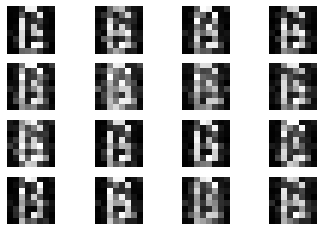

In [26]:
# Training procedure
gen_val, dis_val = training(name=result_dir + name, 
                            num_epochs=num_epochs, 
                            model=model, 
                            optimizer_gen=optimizer_gen,
                            optimizer_dis=optimizer_dis,
                            training_loader=training_loader, 
                            val_loader=val_loader)

In [16]:
test_gen_loss, test_dis_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_gen_loss))
f.write('\n')
f.write(str(test_dis_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name + '_gen', gen_val, yaxis='$log(1-D(G(z))$')
plot_curve(result_dir + name + '_dis', dis_val, yaxis='$-(log(1-D(G(z)) + log(D(x)))$')

samples_generated(result_dir + name, test_loader, extra_name='FINAL')

FINAL LOSS: gen=-0.6655339661327251, dis=1.398517770788547


In [52]:
manual_train_data = torch.from_numpy(val_data.data[4:20])


In [53]:
manual_train_data

tensor([[ 0.,  0., 14.,  ..., 14.,  2.,  0.],
        [ 0.,  0.,  2.,  ..., 15.,  4.,  0.],
        [ 0.,  1., 12.,  ..., 16.,  8.,  0.],
        ...,
        [ 0.,  3., 15.,  ..., 12., 11.,  1.],
        [ 0.,  0.,  7.,  ..., 15.,  2.,  0.],
        [ 0.,  0.,  4.,  ...,  0.,  0.,  0.]])

In [31]:
generator(batch_size = 1).shape

TypeError: forward() got an unexpected keyword argument 'batch_size'

In [28]:
model.state_dict()

OrderedDict([('generator.generator_net.0.weight',
              tensor([[ 0.1687, -0.2223,  0.0053,  ..., -0.1198,  0.0007, -0.1439],
                      [ 0.2042, -0.0981,  0.1214,  ...,  0.2288, -0.0681, -0.2262],
                      [ 0.2269,  0.1268, -0.2573,  ..., -0.0641, -0.2468,  0.0272],
                      ...,
                      [ 0.1756, -0.0027, -0.1148,  ..., -0.1377, -0.2163,  0.0604],
                      [ 0.0201,  0.2489, -0.1184,  ..., -0.1516,  0.3026, -0.0708],
                      [ 0.0661, -0.1068,  0.0082,  ...,  0.1652, -0.0476, -0.2627]])),
             ('generator.generator_net.0.bias',
              tensor([-0.0879,  0.1893, -0.1590,  0.0199,  0.2483, -0.1783, -0.1256, -0.1862,
                      -0.1481,  0.2428,  0.2164,  0.1499,  0.1227, -0.2300,  0.2354,  0.0491,
                       0.0256, -0.0902, -0.1857, -0.1351,  0.0615,  0.1099, -0.1014,  0.2442,
                       0.1787, -0.1417, -0.0545, -0.0526,  0.0026,  0.2312, -0.0858, -

In [54]:
loss_dis = model.forward(manual_train_data, mode='discriminator')                      
optimizer_dis.zero_grad()
optimizer_gen.zero_grad()
loss_dis.backward(retain_graph=True)
optimizer_dis.step()          
loss_gen = model.forward(manual_train_data, mode='generator')         
optimizer_dis.zero_grad()
optimizer_gen.zero_grad()
loss_gen.backward(retain_graph=True)
optimizer_gen.step()

In [62]:
optimizer_gen

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [61]:
model.state_dict()

OrderedDict([('generator.generator_net.0.weight',
              tensor([[ 0.1693, -0.2230,  0.0055,  ..., -0.1203,  0.0011, -0.1448],
                      [ 0.2042, -0.0978,  0.1212,  ...,  0.2285, -0.0682, -0.2259],
                      [ 0.2270,  0.1276, -0.2571,  ..., -0.0643, -0.2461,  0.0273],
                      ...,
                      [ 0.1757, -0.0029, -0.1148,  ..., -0.1370, -0.2152,  0.0604],
                      [ 0.0206,  0.2481, -0.1188,  ..., -0.1506,  0.3023, -0.0702],
                      [ 0.0665, -0.1078,  0.0076,  ...,  0.1660, -0.0479, -0.2631]])),
             ('generator.generator_net.0.bias',
              tensor([-0.0869,  0.1891, -0.1588,  0.0204,  0.2481, -0.1782, -0.1248, -0.1866,
                      -0.1484,  0.2415,  0.2162,  0.1506,  0.1222, -0.2278,  0.2355,  0.0489,
                       0.0255, -0.0907, -0.1869, -0.1344,  0.0609,  0.1104, -0.1002,  0.2432,
                       0.1782, -0.1415, -0.0539, -0.0519,  0.0024,  0.2315, -0.0849, -